# Thread Overlapping
a. stein 4.28.2023

In [1]:
import pickle
import numpy as np

import sys
sys.path.append('../../../')
import ndrought.drought_network as dnet
import ndrought.wrangle_v11 as dnw

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr

from tqdm.autonotebook import tqdm

/pool0/data/steinjao/drought/drought_impact/notebooks/explore/drought_network/../../../ndrought/wrangle.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Load in Data

In [2]:
dnet_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet'

In [3]:
exp_tag = 'f25k_d1_rt20p_paired'

In [4]:
usdm_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/USDM_net_{exp_tag}.pickle')

In [5]:
spi30d_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/spi_30d_net_{exp_tag}.pickle')

In [6]:
spi180d_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/spi_180d_net_{exp_tag}.pickle')

## Grab drought
- 2014/2016: 765,870
- 2004/2006: 244,348
- 2010/2012: 557,661

In [7]:
found_origins = []
found_threads = dict()
found_arrays = dict()

t = tqdm(total=len(usdm_net.origins))

for o in usdm_net.origins:
    if o.time > 557 and o.time < 661:
        found_origins.append(o)
        found_threads[o.id] = usdm_net.get_chronological_future_thread(o.id)
        found_arrays[o.id] = usdm_net.to_array(id=o.id)
        print(o)
        print(found_threads[o.id])
        print()
    t.update()

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for o in found_origins:
    print(len(found_threads[o.id]))
    print(found_threads[o.id][-1])

632
time: 1148, id: 1813, futures: []
632
time: 1148, id: 1813, futures: []
578
time: 1148, id: 1813, futures: []
10
time: 636, id: 1009, futures: []
552
time: 1148, id: 1813, futures: []


In [ ]:
found_origins = []
found_threads = dict()
found_arrays = dict()

t = tqdm(total=len(spi180d_net.origins))

for o in usdm_net.origins:
    if o.time > 557 and o.time < 661:
        found_origins.append(o)
        found_threads[o.id] = spi180d_net.get_chronological_future_thread(o.id)
        found_arrays[o.id] = spi180d_net.to_array(id=o.id)
        print(o)
        print(found_threads[o.id])
        print()
    t.update()

  0%|          | 0/272 [00:00<?, ?it/s]

time: 571, id: 918, futures: [920]
[time: 618, id: 918, time: 619, id: 921, time: 620, id: 924]

time: 571, id: 919, futures: [921]
[time: 618, id: 919, time: 619, id: 922, time: 620, id: 925]

time: 625, id: 985, futures: [987]
[time: 676, id: 985, time: 677, id: 988, time: 678, id: 991, time: 679, id: 995]

time: 627, id: 989, futures: [992]
[time: 678, id: 989, time: 679, id: 992, time: 680, id: 996]

time: 651, id: 1025, futures: [1027]
[time: 716, id: 1025, time: 717, id: 1030]



In [ ]:
for o in found_origins:
    print(len(found_threads[o.id]))
    print(found_threads[o.id][-1])

3
time: 620, id: 924, futures: []
3
time: 620, id: 925, futures: []
4
time: 679, id: 995, futures: []
3
time: 680, id: 996, futures: []
2
time: 717, id: 1030, futures: []


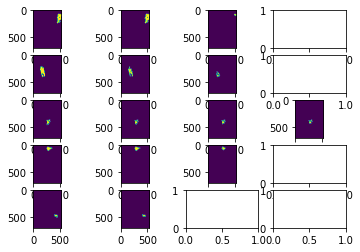

In [ ]:
fig, axs = plt.subplots(5,4)

for i, o in enumerate(found_origins):
    for j, array in enumerate(found_arrays[o.id]):
        axs[i,j].imshow(array)

Okay, that doesn't give me that much to work with. Let's find the biggest event in spi180d and trace from there

In [ ]:
largest_id = 0
largest_size = 0

for node in spi180d_net.nodes:
    if len(node.coords) > largest_size:
        largest_id = node.id
        largest_size = len(node.coords)

In [ ]:
largest_node = spi180d_net.nodes[largest_id]
largest_node

time: 900, id: 1517

In [ ]:
largest_size

86019

In [ ]:
largest_array = spi180d_net.to_array(id=largest_id)
largest_array.shape

(23, 702, 525)

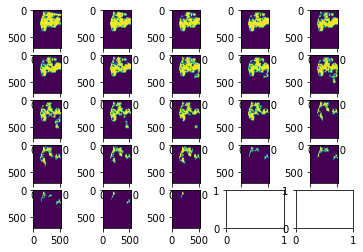

In [ ]:
fig, axs = plt.subplots(5,5)
axs_list = axs.ravel()

for i in np.arange(largest_array.shape[0]):
    axs_list[i].imshow(largest_array[i, :, :])

That's more what I'm talking about.

Now to trace it backwards

In [ ]:
largest_origins = spi180d_net.find_origins(start_id=largest_id)
largest_origins

[1463, 1439, 1434, 1436, 1360, 1361, 1351, 1352]

In [ ]:
for o in largest_origins:
    print(len(spi180d_net.nodes[o].coords))

5985
3682
2410
4344
3614
1949
1599
1681


Are these just events that snowball?

In [ ]:
origin_threads = dict()
origin_thread_ids = dict()

for o in largest_origins:
    origin_threads[o] = spi180d_net.get_chronological_future_thread(id=o)
    origin_thread_ids[o] = [org.id for org in origin_threads[o]]

In [ ]:
test_1 = origin_thread_ids[largest_origins[0]]
test_2 = origin_thread_ids[largest_origins[1]]

In [ ]:
len(test_1)

65

In [ ]:
len(test_2)

79

In [ ]:
len(np.intersect1d(test_1, test_2))

63

In [ ]:
len(np.union1d(test_1, test_2))

81

In [ ]:
for o_1 in largest_origins:
    o_thread_1 = origin_thread_ids[o_1]
    for o_2 in largest_origins:
        o_thread_2 = origin_thread_ids[o_2]
        intersect = np.intersect1d(o_thread_1, o_thread_2)
        if len(intersect) == len(o_thread_1):
            print(f'{o_2} in {o_1}')
        elif len(intersect) == len(o_thread_2):
            print(f'{o_1} in {o_2}')

1463 in 1463
1439 in 1439
1434 in 1434
1436 in 1436
1360 in 1360
1361 in 1361
1351 in 1351
1352 in 1352


In [ ]:
for o_1 in largest_origins:
    o_thread_1 = origin_thread_ids[o_1]
    for o_2 in largest_origins:
        o_thread_2 = origin_thread_ids[o_2]
        intersect = np.intersect1d(o_thread_1, o_thread_2)
        print(f'{o_1}({len(o_thread_1)}) intersect {o_2}({len(o_thread_2)}) --> {len(intersect)}')

1463(65) intersect 1463(65) --> 65
1463(65) intersect 1439(79) --> 63
1463(65) intersect 1434(80) --> 63
1463(65) intersect 1436(81) --> 63
1463(65) intersect 1360(123) --> 64
1463(65) intersect 1361(123) --> 64
1463(65) intersect 1351(126) --> 64
1463(65) intersect 1352(126) --> 64
1439(79) intersect 1463(65) --> 63
1439(79) intersect 1439(79) --> 79
1439(79) intersect 1434(80) --> 78
1439(79) intersect 1436(81) --> 78
1439(79) intersect 1360(123) --> 63
1439(79) intersect 1361(123) --> 63
1439(79) intersect 1351(126) --> 63
1439(79) intersect 1352(126) --> 63
1434(80) intersect 1463(65) --> 63
1434(80) intersect 1439(79) --> 78
1434(80) intersect 1434(80) --> 80
1434(80) intersect 1436(81) --> 79
1434(80) intersect 1360(123) --> 63
1434(80) intersect 1361(123) --> 63
1434(80) intersect 1351(126) --> 63
1434(80) intersect 1352(126) --> 63
1436(81) intersect 1463(65) --> 63
1436(81) intersect 1439(79) --> 78
1436(81) intersect 1434(80) --> 79
1436(81) intersect 1436(81) --> 81
1436(81)

So they're not complete snowballs (as in, they blip one moment then completely match), they have some life before they merge

In [ ]:
spi180d_ln = largest_node # ln = largest node

In [ ]:
spi180d_ln_cs = set(tuple(coord) for coord in spi180d_ln.coords) # cs = coord set

Now I need to select out the node that has the greatest overlap at that time

In [ ]:
spi30d_tm = []

for node in spi30d_net:
    if node.time ==spi180d_ln.time:
        print(node)
        spi30d_tm.append(node)

time: 900, id: 1801, futures: [1804]
time: 900, id: 1802, futures: [1805]
time: 900, id: 1803, futures: [1805]


In [ ]:
for node in spi30d_tm:
    node_cs = set(tuple(coord) for coord in node.coords)
    print(len(spi180d_ln_cs.intersection(node_cs)))

23846
10168
2450


So all 3 of those intersect ... great

In [ ]:
[spi30d_net.find_origins(node.id) for node in spi30d_tm]

[[1789, 1760, 1758, 1751], [1789, 1760, 1758, 1751], []]

In [ ]:
# double check that that last entry means its an origin
spi30d_tm[-1].past

[]

So we got 8 threads that feed into the node for spi180d, and then effectively 9 that feed into spi30d that intersects at the same time.

What about for USDM? (I'm probably going to regret this)

In [ ]:
usdm_tm = []

for node in usdm_net:
    if node.time == spi180d_ln.time:
        print(node)
        usdm_tm.append(node)

time: 900, id: 1374, futures: [1375]


In [ ]:
for node in usdm_tm:
    node_cs = set(tuple(coord) for coord in node.coords)
    print(len(spi180d_ln_cs.intersection(node_cs)))

0


HAHAHAHHAHAAH, they don't even intersect. Wow.

So any overlapping I do I'd need to run it at a different part of the thread

GAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAHHHH

Okay, lets start simple and try running one of the threads against another thread